# Exploratory Data Analysis

### COVID-19 Daily Infections and Deaths Data
#### Importing dataset

In [35]:
root_path = '/home/mbai/python/covid_ds/'
import sys
sys.path.append(root_path)

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns

from etl.constants import ETLConfigs
pd.options.mode.chained_assignment = None

conn = sqlite3.connect("{}{}.db".format(root_path, ETLConfigs.DB_NAME))
query = "SELECT * FROM {}".format(ETLConfigs.TABLE_NAME)

df = pd.read_sql_query(query, conn)

### Initial view of the dataset
Let's get a quick view of the scope and type of dataset we're dealing with:  
Looking at the top/bottom/random 20 rows, data shape, and datatypes

In [36]:
df.head()

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
0,Afghanistan,None,33.0000,65.0000,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
1,Albania,None,41.1533,20.1683,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
2,Algeria,None,28.0339,1.6596,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
3,Andorra,None,42.5063,1.5218,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
4,Angola,None,-11.2027,17.8739,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386


In [37]:
df.tail()

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
352695,US,Utah,38.996171,-110.701396,2020-04-30 00:00:00,-2,0,2020-05-01 17:09:22.385386
352696,US,Utah,37.854472,-111.441876,2020-04-30 00:00:00,5,0,2020-05-01 17:09:22.385386
352697,US,Utah,40.124915,-109.517442,2020-04-30 00:00:00,2,0,2020-05-01 17:09:22.385386
352698,US,Utah,41.271160,-111.914512,2020-04-30 00:00:00,7,0,2020-05-01 17:09:22.385386
352699,US,Utah,NaN,NaN,2020-04-30 00:00:00,0,0,2020-05-01 17:09:22.385386


In [38]:
df.sample(10)

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
122070,US,Kansas,38.346162,-98.199921,2020-02-20 00:00:00,0,0,2020-05-01 17:09:22.385386
64159,US,New Hampshire,43.291833,-71.023360,2020-02-02 00:00:00,0,0,2020-05-01 17:09:22.385386
235798,US,Georgia,34.913692,-83.741075,2020-03-26 00:00:00,0,0,2020-05-01 17:09:22.385386
228146,US,Texas,27.424355,-97.698949,2020-03-23 00:00:00,0,0,2020-05-01 17:09:22.385386
298619,US,Minnesota,44.003741,-92.402099,2020-04-14 00:00:00,4,0,2020-05-01 17:09:22.385386
244698,US,Virginia,38.859051,-78.568138,2020-03-28 00:00:00,0,0,2020-05-01 17:09:22.385386
81955,US,Guam,13.444300,144.793700,2020-02-08 00:00:00,0,0,2020-05-01 17:09:22.385386
240575,US,North Dakota,48.223902,-101.543676,2020-03-27 00:00:00,1,0,2020-05-01 17:09:22.385386
300750,US,California,40.125709,-122.237017,2020-04-15 00:00:00,0,1,2020-05-01 17:09:22.385386
41731,US,Oklahoma,34.023112,-96.768555,2020-01-26 00:00:00,0,0,2020-05-01 17:09:22.385386


In [39]:
df.shape
num_rows = df.shape[0]
num_cols = df.shape[1]

In [40]:
df.dtypes

country           object
state             object
latitude         float64
longitude        float64
date              object
confirmed          int64
death              int64
etl_load_time     object
dtype: object

### A few observations here:

- We have 350k rows of data and 8 columns
- country, state, longitude, and latitude denoting location in the world (labels)
- state has `None` as null value
- confirmed and death for potential prediction (target)
- date and etl_load_time seems to be stored as `string` rather than `datetime`
- `etl_load_time` seems obsolete for this purpose

Let's drop `etl_load_time` and convert `date` to the proper datatype

In [41]:
df['date'] = df['date'].astype('datetime64', copy=False)
df.drop(columns=['etl_load_time'], inplace=True, errors='ignore')
df.replace({None: np.NaN}, inplace=True)

df.dtypes

country              object
state                object
latitude            float64
longitude           float64
date         datetime64[ns]
confirmed             int64
death                 int64
dtype: object

### Searching and dealing with *null*

Figure out the scope of the nulls  
Visualize missing values with missingno  

In [57]:
import missingno as msno

print(f"Out of {num_rows} rows")
for i in df:
    missing = df[i].isnull().sum()
    miss_perc = round(missing / num_rows, 3)
    print(f"Row {i} has {missing} nulls, or about {miss_perc}%")

Out of 352700 rows
Row country has 0 nulls, or about 0.0%
Row state has 18300 nulls, or about 0.052%
Row latitude has 100 nulls, or about 0.0%
Row longitude has 100 nulls, or about 0.0%
Row date has 0 nulls, or about 0.0%
Row confirmed has 0 nulls, or about 0.0%
Row death has 0 nulls, or about 0.0%


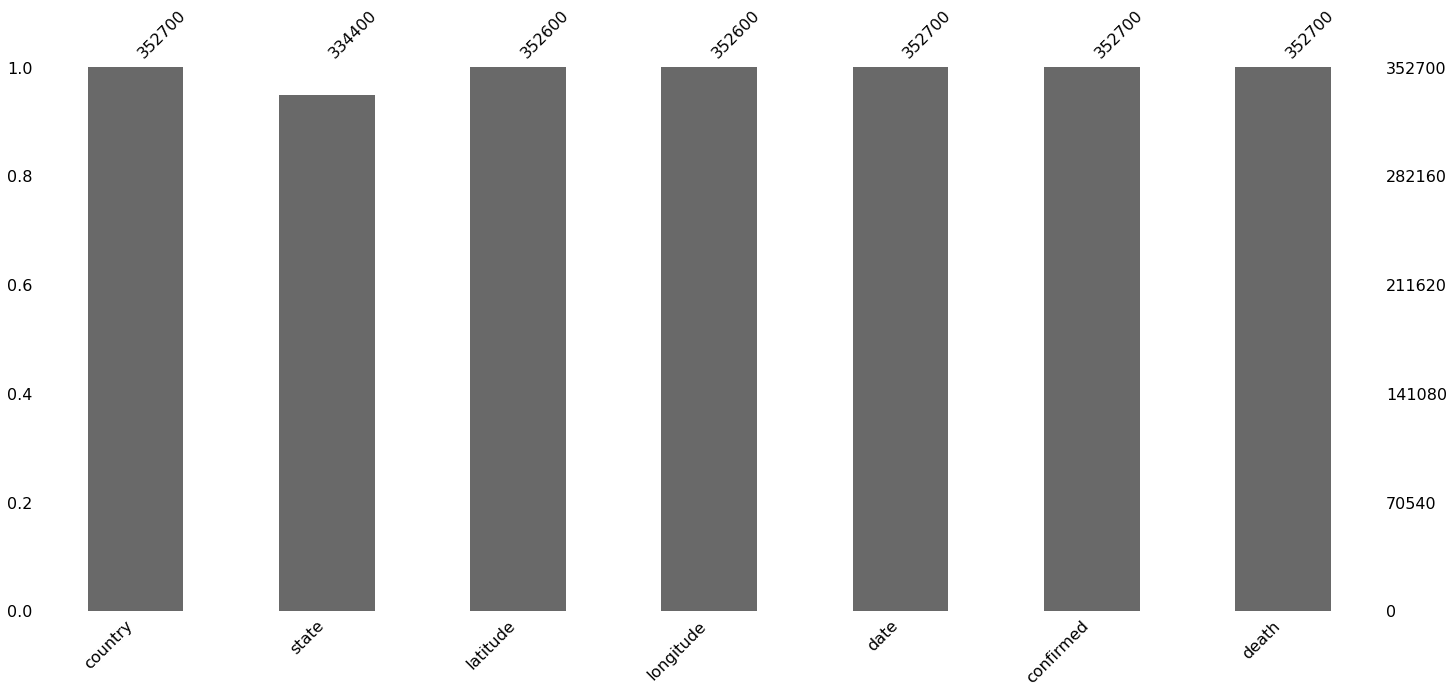

In [55]:
msno.bar(df)

Looks like `longitude` and `latitude` labels both has a small numbers of nulls  
Let's see which index they are are originating form, based on their country and state

In [81]:
log_lat_null_df = df[(
    ((df["longitude"].isnull()) & (df["latitude"].isnull()))
)]
print(log_lat_null_df['country'].unique())
print(log_lat_null_df['state'].unique())

['US']
['Utah']


Okay... US and Utah. See if they normally have any values?

In [84]:
log_lat_null_df.groupby(["country"]).sum()

,latitude,longitude,confirmed,death
country,,,,
US,0.0,0.0,0,0


Nice. No useful values. Let's drop

In [95]:
df_null_step1 = df[(
        ~((df["longitude"].isnull()) & (df["latitude"].isnull()))
    )]
print(f"Previous rows were {num_rows}")
new_num_rows = df_null_step1.shape[0]
print(f"Now there are {new_num_rows}")

Previous rows were 352700
Now there are 352600
